In [0]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import sys
if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from google.colab import drive
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
from keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate, Activation,  add
from tensorflow.keras import Input

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
AUTO = tf.data.experimental.AUTOTUNE

## Read data

In [0]:
IMG_SIZE = [32, 32]
BATCH_SIZE = 128

In [0]:
(X, Y), (X_test, Y_test) = cifar10.load_data()
Y = to_categorical(Y, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

In [82]:
X.shape, Y.shape, X_test.shape, Y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [0]:
label_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

## Normalize data

In [84]:
np.isnan(X).sum(), np.isnan(X_test).sum()

(0, 0)

In [0]:
def norm_data(X):
  X = X / 255.0

  return X

In [0]:
X = norm_data(X)
X_test = norm_data(X_test)

In [87]:
X.mean(), X_test.mean()

(0.4733630004850874, 0.47658492059844665)

## Convert Data to batches and augment data

In [0]:
def data_augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

  return image, label

In [0]:
def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.repeat()
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(1337)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [0]:
X = tf.dtypes.cast(X, tf.float32)
Y = tf.dtypes.cast(Y, tf.float32)
tf.keras.backend.set_floatx('float32')

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train = get_batched_dataset(train_dataset, train=True)
test = get_batched_dataset(test_dataset)

## ResNet architecture

In [0]:
def lr_fun(x):
  lr = 1e-3
  
  if x > 25:
    lr *= 1e-1
  elif x > 100:
    lr *= 1e-2
   
  return lr

In [0]:
def conv_module(x, dims=-1):
  if dims == -1:
    dims = x.shape[3]

  y1 = Conv2D(dims, 3, padding='same', strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y1 = BatchNormalization()(y1)
  y1 = Activation('relu')(y1)
  y1 = Conv2D(dims, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y1)
  y1 = BatchNormalization()(y1)
  y1 = Activation('relu')(y1)

  y2 = Conv2D(dims, 3, padding='same', strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y2 = BatchNormalization()(y2)
  y2 = Activation('relu')(y2)
  y2 = Conv2D(dims, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y2)
  y2 = BatchNormalization()(y2)
  y2 = Activation('relu')(y2)

  y3 = Conv2D(dims, 1, padding='same', strides=2)(x)
  y3 = BatchNormalization()(y4)

  return add([y1, y2, y3])

In [0]:
def identity_module(x):
  dims = x.shape[3]

  y1 = Conv2D(dims, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y1 = BatchNormalization()(y1)
  y1 = Activation('relu')(y1)
  y1 = Conv2D(dims, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y1)
  y1 = BatchNormalization()(y1)
  y1 = Activation('relu')(y1)

  y2 = Conv2D(dims, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y2 = BatchNormalization()(y2)
  y2 = Activation('relu')(y2)
  y2 = Conv2D(dims, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y2)
  y2 = BatchNormalization()(y2)
  y2 = Activation('relu')(y2)

  return add([x, y1, y2])

In [0]:
def create_resnet():
  x = Input(shape=(*IMG_SIZE, 3))
  
  y = Conv2D(16, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y = Dropout(0.1)(y)

  y = conv_module(y, 64)
  y = identity_module(y)
  y = Dropout(0.15)(y)

  y = conv_module(y, 128)
  y = identity_module(y)
  y = Dropout(0.2)(y)

  y = conv_module(y, 256)
  y = identity_module(y)
  y = Dropout(0.25)(y)

  y = AveragePooling2D(pool_size=4)(y)
  y = Flatten()(y)
  y = Dense(10, activation='softmax', kernel_initializer='he_normal')(y)

  model = tf.keras.Model(x, y)

  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      metrics=['accuracy']
      )
  
  return model

## Model creation and training

In [67]:
model = create_resnet()

model.count_params()

5465738

In [68]:
EPOCHS = 30

annealer = tf.keras.callbacks.LearningRateScheduler(lr_fun)
steps_per_epoch = X.shape[0] // BATCH_SIZE

history = model.fit(train,
                    steps_per_epoch=steps_per_epoch, 
                    epochs=EPOCHS, 
                    validation_data=test,
                    callbacks=[annealer]
                    )

Epoch 1/30
390/390 [==============================] - 16s 41ms/step - loss: 2.2623 - accuracy: 0.4508 - val_loss: 2.3742 - val_accuracy: 0.4621 - lr: 0.0010
Epoch 2/30
390/390 [==============================] - 15s 39ms/step - loss: 1.6099 - accuracy: 0.6444 - val_loss: 1.7255 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 3/30
390/390 [==============================] - 15s 39ms/step - loss: 1.3016 - accuracy: 0.7210 - val_loss: 1.2683 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 4/30
390/390 [==============================] - 15s 39ms/step - loss: 1.1187 - accuracy: 0.7646 - val_loss: 1.1935 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/30
390/390 [==============================] - 15s 39ms/step - loss: 1.0032 - accuracy: 0.7885 - val_loss: 1.1879 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 6/30
390/390 [==============================] - 15s 39ms/step - loss: 0.9138 - accuracy: 0.8114 - val_loss: 1.1208 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 7/30
390/390 [==============================] - 15s 

In [69]:
scores = model.evaluate(test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

79/79 [==============================] - 1s 14ms/step - loss: 0.6366 - accuracy: 0.9027
Test loss: 0.6365583539009094
Test accuracy: 0.9027000069618225


In [0]:
def display_training_curves(training, validation, title, subplot):
  #stolen from google cnn tutorial
  if subplot%10==1:
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

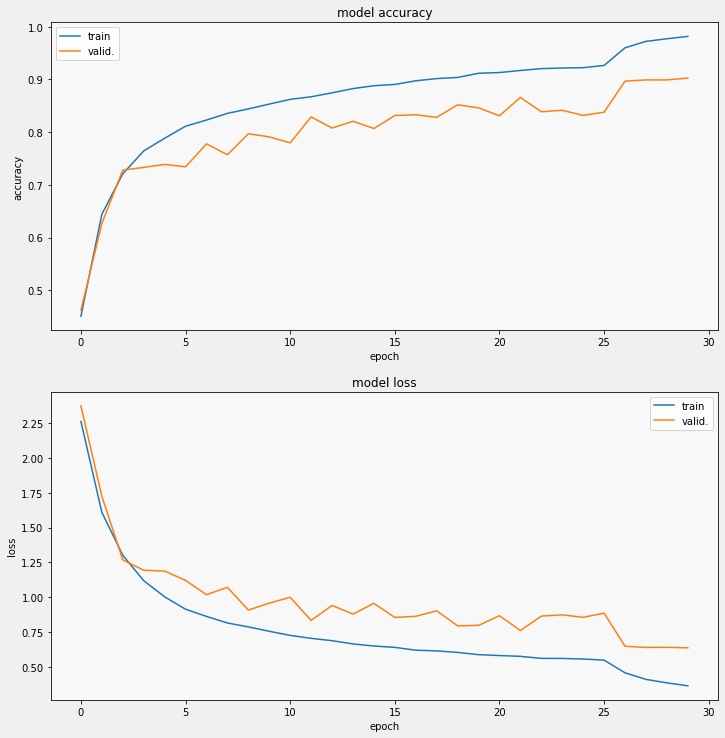

In [71]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## View some examples

In [0]:
def plot_CIFAR(X, ind):
    pic = X[ind]
    R = pic[:,:,0]
    G = pic[:,:,1]
    B = pic[:,:,2]
 
    img = np.dstack((R,G,B))
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')


In [0]:
def prediction_vs_true(X, ind):
  predicted_label = label_names[np.argmax(model.predict(tf.expand_dims(X[ind], 0)))]
  print("Model prediction:", predicted_label)
  print("Correct prediction:", label_names[np.argmax(Y[ind])])

Model prediction: automobile
Correct prediction: automobile


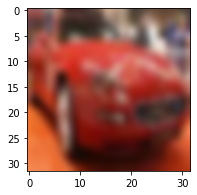

In [74]:
plot_CIFAR(X, 5)
prediction_vs_true(X, 5)

Model prediction: horse
Correct prediction: horse


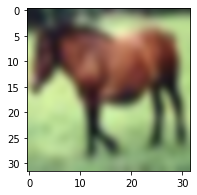

In [75]:
plot_CIFAR(X, 7)
prediction_vs_true(X, 7)

Model prediction: airplane
Correct prediction: airplane


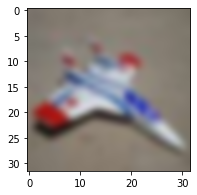

In [76]:
plot_CIFAR(X, 30)
prediction_vs_true(X, 30)

Model prediction: deer
Correct prediction: deer


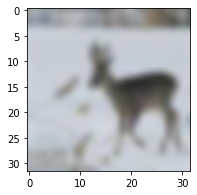

In [77]:
plot_CIFAR(X, 20)
prediction_vs_true(X, 20)